# <font color='purple'>ML Prediction - With Neural Networks </font>

In [360]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from functools import reduce
from tensorflow import keras as ks
from operator import itemgetter

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, Normalizer

# Modeling & Model selection
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Configurations
pd.options.mode.chained_assignment = None

## Help Functions

This function is meant for combining all data we have into a single Dataframe which contains a row for each product, thus making data like the nutrients available at the product level.

We also merge it with our previous predictions from the CNN we created, and the predictions are added as another feature.

In [361]:
def prepare_unified_df(test=False):
    ntr = pd.read_csv("./data/nutrients.csv")
    food_ntr = pd.read_csv("./data/food_nutrients.csv")
    
    ntr_combined = food_ntr.merge(ntr, on='nutrient_id', how='left')
    all_ntr_lists = ntr_combined.groupby("idx")["name"].apply(list).apply(lambda x: " ".join(x))
    idx_nutrients = pd.DataFrame(all_ntr_lists).rename(columns={"name": "nutrients_list"})
    
    if test:
        food = pd.read_csv("./data/food_test.csv")
    else:
        food = pd.read_csv("./data/food_train.csv")
        
    comb = food.merge(idx_nutrients, on="idx")
    
    return comb

In [362]:
def load_train_data():
    # Returns train data seperated in to features (X) df and target series (y)
    df = prepare_unified_df(test=False)
    # Shuffle the dataset
#     df = df.sample(frac=1, random_state=1).reset_index(drop=True)
    X = df.drop(["category"], axis=1)
    y = df["category"]
    return X, y

In [363]:
def load_test_data():
    # Returns features (X) of test data
    return prepare_unified_df(test=True)

This function is meant for:

-  "Cleaning" existing columns like 'description', 'ingredients' and 'household_serving_fulltext' by filling Null values and more

-  Combining the brand's name, the descrition and the household_serving_fulltext together to 1 column named 'text' - just becuase they are pretty similar in their meaning.

In [364]:
def preprocess(df, with_cnn=False):
    df["description"] = df["description"].str.strip('“').str.strip('”').str.strip('"')
    df["brand"] = df["brand"].fillna("")
    df["ingredients"] = df["ingredients"].fillna("")  # Some Null values
    df["household_serving_fulltext"] = df["household_serving_fulltext"].fillna("")  # Some Null values
    df["text"] = reduce(lambda x, y: x + " " + y, (df[x].fillna("") for x in [
                                                                            "brand", 
                                                                            "description", 
                                                                            "household_serving_fulltext"
                                                                            ]))
    if with_cnn:
        df = df[["brand", "text", "ingredients", "nutrients_list", "serving_size", "cnn_prediction"]]
        return df
    
    df = df[["brand", "text", "ingredients", "nutrients_list", "serving_size"]]
    return df

**Prepare input data**

In [365]:
def add_num_of_ings_col(df):
    df['n_ingredients'] = df['ingredients'].apply(lambda x: len(str(x).split(',')))
    return df

In [366]:
def is_choc_in_row(v):
    for i in v:
        if type(i) == str:
            if 'chocolate' in i.lower().strip():
                return 'chocolate'
    return 'no chocolate'

In [367]:
def on_field(f: str, *vec) -> Pipeline:
    return make_pipeline(FunctionTransformer(itemgetter(f), validate=False), *vec)

In [368]:
def create_vectorizer(with_cnn=False):
    if with_cnn:
        vectorizer = make_union(
        on_field('brand', Tfidf(max_features=4000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('cnn_prediction', Tfidf(max_features=6, token_pattern='\w+', ngram_range=(1, 1))),
        on_field('text', Tfidf(max_features=10000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('ingredients', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('nutrients_list', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('is_chocolate_in_text', Tfidf(max_features=2, token_pattern='\w+', ngram_range=(1, 1))),
        on_field(['serving_size', 'n_ingredients'], FunctionTransformer(lambda x: x, validate=False)),
        n_jobs=4
        )
        return vectorizer
        
    vectorizer = make_union(
        on_field('brand', Tfidf(max_features=4000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('text', Tfidf(max_features=10000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('ingredients', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('nutrients_list', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('is_chocolate_in_text', Tfidf(max_features=2, token_pattern='\w+', ngram_range=(1, 1))),
        on_field(['serving_size', 'n_ingredients'], FunctionTransformer(lambda x: x, validate=False)),
        n_jobs=4
    )
    return vectorizer

This function is meant for preparing the X_train and X_test dataframes to be exactly as the NN model expects them to be. Here we:
- Preprocess the data
- Create the 'n_ingredients' 'is_chocolate_in_text' and features
- scale the 'serving_size' and 'n_ingredients' features
- Vectorize all text columns with TfidfVectorizer

(Code is hidden as function is unfortunately long, appears in notebook)

In [369]:
def prepare_inputs(X_train, X_test, X_valid=None, has_valid=True, with_cnn=False):
    
    # Load actual test data
    actual_test_data = load_test_data()
    
    preprocessed_X_train = preprocess(X_train, with_cnn=with_cnn)
    preprocessed_X_test = preprocess(X_test, with_cnn=with_cnn)
    preprocessed_actual_test_data = preprocess(actual_test_data, with_cnn=with_cnn)
    
    # Create new feature: Number of ingredints
    preprocessed_X_train = add_num_of_ings_col(preprocessed_X_train)
    preprocessed_X_test = add_num_of_ings_col(preprocessed_X_test)
    preprocessed_actual_test_data = add_num_of_ings_col(preprocessed_actual_test_data)
    
    # Create new feature: Does the string "chocolate" appears somewhere in all text features
    preprocessed_X_train["is_chocolate_in_text"] = preprocessed_X_train.apply(is_choc_in_row, axis=1)
    preprocessed_X_test["is_chocolate_in_text"] = preprocessed_X_test.apply(is_choc_in_row, axis=1)
    preprocessed_actual_test_data["is_chocolate_in_text"] = preprocessed_actual_test_data.apply(is_choc_in_row, axis=1)
    
    # Scale numeric parameters
    scaler = StandardScaler()
    scaler.fit(preprocessed_X_train.serving_size.values.reshape(-1, 1))
    preprocessed_X_train["serving_size"] = scaler.transform(preprocessed_X_train.serving_size.values.reshape(-1, 1))
    preprocessed_X_test["serving_size"] = scaler.transform(preprocessed_X_test.serving_size.values.reshape(-1, 1))
    preprocessed_actual_test_data["serving_size"] = scaler.transform(preprocessed_actual_test_data.serving_size.values.reshape(-1, 1))
    
    scaler = StandardScaler()
    scaler.fit(preprocessed_X_train.n_ingredients.values.reshape(-1, 1))
    preprocessed_X_train["n_ingredients"] = scaler.transform(preprocessed_X_train.n_ingredients.values.reshape(-1, 1))
    preprocessed_X_test["n_ingredients"] = scaler.transform(preprocessed_X_test.n_ingredients.values.reshape(-1, 1))
    preprocessed_actual_test_data["n_ingredients"] = scaler.transform(preprocessed_actual_test_data.n_ingredients.values.reshape(-1, 1))
    
    if with_cnn:
        vectorizer_cnn = create_vectorizer(with_cnn=True)
        X_train_enc = vectorizer_cnn.fit_transform(preprocessed_X_train).astype(np.float32).toarray()
        X_test_enc = vectorizer_cnn.transform(preprocessed_X_test).astype(np.float32).toarray()
        actual_test_data_enc = vectorizer_cnn.transform(preprocessed_actual_test_data).astype(np.float32).toarray()
    else:
        vectorizer = create_vectorizer()
        X_train_enc = vectorizer.fit_transform(preprocessed_X_train).astype(np.float32).toarray()
        X_test_enc = vectorizer.transform(preprocessed_X_test).astype(np.float32).toarray()
        actual_test_data_enc = vectorizer.transform(preprocessed_actual_test_data).astype(np.float32).toarray()
    
    if has_valid:
        preprocessed_X_valid = preprocess(X_valid, with_cnn=with_cnn)
        preprocessed_X_valid = add_num_of_ings_col(preprocessed_X_valid)
        preprocessed_X_valid["is_chocolate_in_text"] = preprocessed_X_valid.apply(is_choc_in_row, axis=1)
        preprocessed_X_valid["serving_size"] = scaler.transform(preprocessed_X_valid.serving_size.values.reshape(-1, 1))
        preprocessed_X_valid["n_ingredients"] = scaler.transform(preprocessed_X_valid.n_ingredients.values.reshape(-1, 1))
        X_valid_enc = vectorizer.transform(preprocessed_X_valid).astype(np.float32).toarray()
        
        return X_train_enc, X_valid_enc, X_test_enc, actual_test_data_enc

    return X_train_enc, X_test_enc, actual_test_data_enc

**Prepare target data**

This function is meant for preparing the y_train and y_test arrays to be exactly as the NN model expects them to be. Here we encode the labels, and then use OH encoding to transform the data into the correct format for the NN.

In [370]:
def prepare_targets(y_train, y_test, y_valid=None, has_valid=True):
    le = LabelEncoder()
    le.fit(y_train)
    
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    # One Hot encoding for output
    y_train_enc = np_utils.to_categorical(y_train_enc)
    y_test_enc = np_utils.to_categorical(y_test_enc)
    
    if has_valid:
        y_valid_enc = le.transform(y_valid)
        y_valid_enc = np_utils.to_categorical(y_valid_enc)
        
        return y_train_enc, y_valid_enc, y_test_enc
    
    return y_train_enc, y_test_enc

function for preparing all needed data for model:
(Code is hidden, appears in notebook)

In [386]:
mapping = {
    0: "cakes_cupcakes_snack_cakes",
    1: "candy", 
    2: "chips_pretzels_snacks",
    3: "chocolate",
    4: "cookies_biscuits",
    5: "popcorn_peanuts_seeds_related_snacks"
}

In [371]:
def get_data_for_model(test_size, with_valid=False, valid_size=0.1, random_state=1, with_cnn=False):
    # Load data
    X, y = load_train_data()
    
    if with_cnn:
        cnn_df = pd.DataFrame()
        for category_name in mapping.values():
            tmp_df = pd.read_csv(f"./cnn_predictions/{category_name}.csv")
            cnn_df = pd.concat([cnn_df, tmp_df])
        cnn_df = cnn_df.astype(int)
        cnn_df = cnn_df.sort_values('img', ignore_index=True)
        cnn_df = cnn_df.rename(columns={"prediction": "cnn_prediction"})

        X = X.merge(cnn_df, left_on="idx", right_on="img")

        X["cnn_prediction"] = X.cnn_prediction.apply(lambda x: mapping[x])

    # Split to test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    if with_valid:
        # Split rest to train and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=random_state)
        # Prepare input data (X)
        X_train, X_valid, X_test, _ = prepare_inputs(X_train, X_test, X_valid, with_cnn=with_cnn)
        # prepare target data (Y)
        y_train, y_valid, y_test = prepare_targets(y_train, y_test, y_valid)
        
        # Sanity check
        print("Train:")
        print(f'\tX_train: {X_train.shape} of {X_train.dtype}')
        print(f'\ty_train: {y_train.shape} of {y_train.dtype}')
        print("Validation:")
        print(f'\tX_valid: {X_valid.shape} of {X_valid.dtype}')
        print(f'\ty_valid: {y_valid.shape} of {y_valid.dtype}')
        print("Test:")
        print(f'\tX_test: {X_test.shape} of {X_test.dtype}')
        print(f'\ty_test: {y_test.shape} of {y_test.dtype}')
        
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    else:
        # Prepare input data (X)
        X_train, X_test, _ = prepare_inputs(X_train, X_test, has_valid=False, with_cnn=with_cnn)
        # prepare target data (Y)
        y_train, y_test = prepare_targets(y_train, y_test, has_valid=False)
        
        print("Train:")
        print(f'\tX_train: {X_train.shape} of {X_train.dtype}')
        print(f'\ty_train: {y_train.shape} of {y_train.dtype}')
        print("Test:")
        print(f'\tX_test: {X_test.shape} of {X_test.dtype}')
        print(f'\ty_test: {y_test.shape} of {y_test.dtype}')
        
        return X_train, X_test, y_train, y_test

Function for plotting the train and validation accuracy:

In [372]:
def plot_accuracy(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    # range of X (no. of epochs)
    epochs = range(1, len(acc) + 1)

    # plot
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**First model creation:**

This model configuration was chosen after we tried several different parameters manually, such as number of layers (3 always seemed to work better than 2), number of nuerons per layer and the dropout rate. But we'll do some CV later!

In [373]:
def create_model(dp=0.4, optimizer='adam', num_nuerons=[128, 32, 16]):
    model_in = ks.Input(shape=(INPUT_SHAPE,), dtype='float32', sparse=True)
    out = ks.layers.Dense(num_nuerons[0], activation='relu')(model_in)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(num_nuerons[1], activation='relu')(out)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(num_nuerons[2], activation='relu')(out)
    out = ks.layers.Dense(6, activation='softmax')(out)
    model = ks.Model(model_in, out)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # rmsprop/adam
    return model

In [374]:
# Early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,  # stop training when there's no improvement in val_loss for 10 consecutive epochs
    restore_best_weights=True
)

## 1st Model

### Get Data & Run NN Model

In [345]:
# Get data
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data_for_model(
    test_size=0.15,
    with_valid=True,
    valid_size=0.1
)

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}
Train:
	X_train: (24289, 16439) of float32
	y_train: (24289, 6) of float32
Validation:
	X_valid: (2699, 16439) of float32
	y_valid: (2699, 6) of float32
Test:
	X_test: (4763, 16439) of float32
	y_test: (4763, 6) of float32


In [346]:
# Create model
INPUT_SHAPE = X_train.shape[1]
model = create_model()

# Fit model on training data
history = model.fit(
    X_train,
    y_train,
    callbacks=[es],
    epochs=10000,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    verbose=2
)

Epoch 1/10000
760/760 - 4s - loss: 0.5122 - accuracy: 0.8295 - val_loss: 0.2382 - val_accuracy: 0.9322 - 4s/epoch - 6ms/step
Epoch 2/10000
760/760 - 3s - loss: 0.2196 - accuracy: 0.9332 - val_loss: 0.2416 - val_accuracy: 0.9337 - 3s/epoch - 4ms/step
Epoch 3/10000
760/760 - 3s - loss: 0.1623 - accuracy: 0.9487 - val_loss: 0.2613 - val_accuracy: 0.9252 - 3s/epoch - 4ms/step
Epoch 4/10000
760/760 - 3s - loss: 0.1314 - accuracy: 0.9571 - val_loss: 0.2900 - val_accuracy: 0.9307 - 3s/epoch - 4ms/step
Epoch 5/10000
760/760 - 3s - loss: 0.1101 - accuracy: 0.9650 - val_loss: 0.2897 - val_accuracy: 0.9337 - 3s/epoch - 4ms/step
Epoch 6/10000
760/760 - 3s - loss: 0.0925 - accuracy: 0.9691 - val_loss: 0.3236 - val_accuracy: 0.9329 - 3s/epoch - 4ms/step
Epoch 7/10000
760/760 - 3s - loss: 0.0810 - accuracy: 0.9725 - val_loss: 0.3445 - val_accuracy: 0.9303 - 3s/epoch - 4ms/step
Epoch 8/10000
760/760 - 3s - loss: 0.0704 - accuracy: 0.9742 - val_loss: 0.3530 - val_accuracy: 0.9322 - 3s/epoch - 4ms/step


### Evaluate Model

**Plotting training and validation accuracy:**

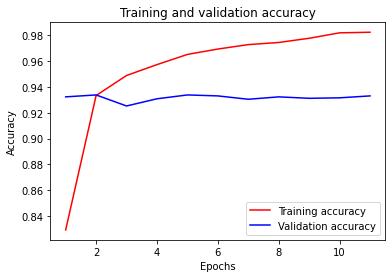

In [348]:
plot_accuracy(history)

**Classification Report on validation data:**

(validation data was used by the model for estimating performance, but model was not trained on it!)

In [349]:
preds = model.predict(X_valid, verbose=0)
# Classification report
print(classification_report(y_valid.argmax(axis=1), preds.argmax(axis=1)))
_, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print('Accuracy on validation: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       335
           1       0.94      0.90      0.92       620
           2       0.98      0.96      0.97       335
           3       0.80      0.89      0.84       319
           4       0.96      0.93      0.94       454
           5       0.96      0.94      0.95       636

    accuracy                           0.93      2699
   macro avg       0.93      0.93      0.93      2699
weighted avg       0.93      0.93      0.93      2699

Accuracy on validation: 93.22


**Classification Report on test data:**

In [350]:
preds = model.predict(X_test, verbose=0)
# Classification report
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       565
           1       0.96      0.91      0.93      1120
           2       0.97      0.96      0.97       536
           3       0.82      0.91      0.86       591
           4       0.93      0.95      0.94       818
           5       0.97      0.96      0.96      1133

    accuracy                           0.94      4763
   macro avg       0.93      0.94      0.94      4763
weighted avg       0.94      0.94      0.94      4763

Accuracy on test: 93.83


### Before we continue, let's train this model on all data and save a prediction in the test set, in case this will be one of our final models:

In [351]:
train_data, y = load_train_data()
train_data, _, test_data = prepare_inputs(train_data, train_data, has_valid=False)

y, _ = prepare_targets(y, y, has_valid=False)

print("Train:")
print(f'\ttrain_data: {train_data.shape} of {train_data.dtype}')
print(f'\ty: {y.shape} of {y.dtype}')
print("Test:")
print(f'\ttest_data: {test_data.shape} of {test_data.dtype}')

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}
Train:
	train_data: (31751, 16446) of float32
	y: (31751, 6) of float32
Test:
	test_data: (3525, 16446) of float32


In [352]:
# Create model
INPUT_SHAPE = train_data.shape[1]
model = create_model()

# Fit model on all train data
history = model.fit(
    train_data,
    y,
    epochs=10,  # We see that there's almost no improvement after a couple of epochs, so we need it to avoid overfitting.
    shuffle=True,
    verbose=0
)

#### Sanity check on train data

In [353]:
preds = model.predict(train_data, verbose=0)
# Classification report
print(classification_report(y.argmax(axis=1), preds.argmax(axis=1)))
_, accuracy = model.evaluate(train_data, y, verbose=0)
print('Accuracy on validation: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3786
           1       0.99      0.97      0.98      7584
           2       1.00      1.00      1.00      3680
           3       0.94      0.98      0.96      3772
           4       1.00      0.99      0.99      5284
           5       1.00      0.99      1.00      7645

    accuracy                           0.99     31751
   macro avg       0.99      0.99      0.99     31751
weighted avg       0.99      0.99      0.99     31751

Accuracy on validation: 98.88


#### Predict on test data and save results

In [354]:
preds = model.predict(test_data).argmax(axis=1)

mapping = {
    0: "cakes_cupcakes_snack_cakes",
    1: "candy", 
    2: "chips_pretzels_snacks",
    3: "chocolate",
    4: "cookies_biscuits",
    5: "popcorn_peanuts_seeds_related_snacks"
}

preds = [mapping[i] for i in preds]

test_indexes = load_test_data().idx

111/111 [==============================] - 0s 2ms/step


In [355]:
results_model_03 = pd.DataFrame({"idx": indexes, "pred_cat": preds})
results_model_03.to_csv("model_03.csv", index=False)

# For sanity check
t = load_test_data()
t["pred_cat"] = preds
t.to_csv("model_03_check.csv", index=False)

**Notice:** Here you see creation of model 3, which includes the "is_chocolate" feature. Model 1 which we created is the same model, but without this feature, and was run before this feature was added to our code.

### Conclusions until now:

1) We see that the precision and recall of all 6 categories are pretty similar, so we can assure ourselves that using accuracy is indeed OK.

2) We see that we get a pretty good accuracy without needing to do any complicated manipulations on the tabular data, and overall it really makes sense, as we saw in the data exploration step that the data is mostly text, and that these texts, such as brand, description and ingredients, hold most of the information we need to know the category. So, by using Tfidf to convert the text to TF-IDF features, we really use all this information.

3) We also see that the validation accuracy doesn't really go up, so we need to be cautious of overfitting. It seems that increasing the epochs is definitely not the solution (we're just staying with the same validation accuracy), so improving the model with have to come from improving the hyperparameters or adding additional data.

4) We can see that the f1 score of category #3 (it's choclate) is very low compared to all other categories. That means that we do a not-so-good job at predicting the Choclate category, and we need to go back to the data and see if there's some information that we can use to improve this.

So, this is going to be our next step!

## 2nd Model:  Adding additional params to improve *Choclate* classification

#### Updating relevant functions:
For now we create new versions of create_vectorizer and prepare_inputs, as we're not sure yet we want this feature in our final model (Code is hidden, appears in notebook)

In [375]:
def is_choc_in_row(v):
    for i in v:
        if type(i) == str:
            if 'chocolate' in i.lower().strip():
                return 'chocolate'
    return 'no chocolate'

def create_vectorizer_2():
    vectorizer = make_union(
        on_field('brand', Tfidf(max_features=4000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('text', Tfidf(max_features=10000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('ingredients', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('nutrients_list', Tfidf(max_features=2000, token_pattern='\w+', ngram_range=(1, 2))),
        on_field('is_chocolate_in_text', Tfidf(max_features=2, token_pattern='\w+', ngram_range=(1, 1))),
        on_field(['serving_size', 'n_ingredients'], 
                 FunctionTransformer(lambda x: x, validate=False))
    )
    return vectorizer


def prepare_inputs_2(X_train, X_test, X_valid=None, has_valid=True):
    preprocessed_X_train = preprocess(X_train)
    preprocessed_X_test = preprocess(X_test)
    
    # Create new feature: Number of ingredints
    preprocessed_X_train = add_num_of_ings_col(preprocessed_X_train)
    preprocessed_X_test = add_num_of_ings_col(preprocessed_X_test)
    
    # Create new feature:
    preprocessed_X_train["is_chocolate_in_text"] = preprocessed_X_train.apply(is_choc_in_row, axis=1)
    preprocessed_X_test["is_chocolate_in_text"] = preprocessed_X_test.apply(is_choc_in_row, axis=1)
    
    # Scale numeric parameters
    scaler = StandardScaler()
    scaler.fit(preprocessed_X_train.serving_size.values.reshape(-1, 1))
    preprocessed_X_train["serving_size"] = scaler.transform(preprocessed_X_train.serving_size.values.reshape(-1, 1))
    preprocessed_X_test["serving_size"] = scaler.transform(preprocessed_X_test.serving_size.values.reshape(-1, 1))
    
    scaler = StandardScaler()
    scaler.fit(preprocessed_X_train.n_ingredients.values.reshape(-1, 1))
    preprocessed_X_train["n_ingredients"] = scaler.transform(preprocessed_X_train.n_ingredients.values.reshape(-1, 1))
    preprocessed_X_test["n_ingredients"] = scaler.transform(preprocessed_X_test.n_ingredients.values.reshape(-1, 1))
    
    # Vectorize
    vectorizer = create_vectorizer_2()
    X_train_enc = vectorizer.fit_transform(preprocessed_X_train).astype(np.float32).toarray()
    X_test_enc = vectorizer.transform(preprocessed_X_test).astype(np.float32).toarray()
    
    if has_valid:
        preprocessed_X_valid = preprocess(X_valid)
        preprocessed_X_valid = add_num_of_ings_col(preprocessed_X_valid)
        preprocessed_X_valid["is_chocolate_in_text"] = preprocessed_X_valid.apply(is_choc_in_row, axis=1)
        preprocessed_X_valid["serving_size"] = scaler.transform(preprocessed_X_valid.serving_size.values.reshape(-1, 1))
        preprocessed_X_valid["n_ingredients"] = scaler.transform(preprocessed_X_valid.n_ingredients.values.reshape(-1, 1))
        X_valid_enc = vectorizer.transform(preprocessed_X_valid).astype(np.float32).toarray()
        
        return X_train_enc, X_valid_enc, X_test_enc
    
 
    return X_train_enc, X_test_enc

### Prepare data & Run NN model with new feature

In [381]:
# Prepare data
X, y = load_train_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
# Use prepare_inputs_2 functions and not original one
X_train, X_valid, X_test = prepare_inputs_2(X_train, X_test, X_valid)
y_train, y_valid, y_test = prepare_targets(y_train, y_test, y_valid)

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}


In [382]:
# Create model
INPUT_SHAPE = X_train.shape[1]
model = create_model()

# Fit model on training data
history = model.fit(
    X_train,
    y_train,
    callbacks=[es],
    epochs=10000,
    batch_size=16,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    verbose=2
)

Epoch 1/10000
1519/1519 - 6s - loss: 0.4669 - accuracy: 0.8483 - val_loss: 0.2398 - val_accuracy: 0.9244 - 6s/epoch - 4ms/step
Epoch 2/10000
1519/1519 - 5s - loss: 0.2046 - accuracy: 0.9352 - val_loss: 0.2352 - val_accuracy: 0.9326 - 5s/epoch - 4ms/step
Epoch 3/10000
1519/1519 - 6s - loss: 0.1604 - accuracy: 0.9486 - val_loss: 0.2384 - val_accuracy: 0.9333 - 6s/epoch - 4ms/step
Epoch 4/10000
1519/1519 - 5s - loss: 0.1278 - accuracy: 0.9584 - val_loss: 0.2559 - val_accuracy: 0.9363 - 5s/epoch - 4ms/step
Epoch 5/10000
1519/1519 - 6s - loss: 0.1071 - accuracy: 0.9650 - val_loss: 0.2920 - val_accuracy: 0.9366 - 6s/epoch - 4ms/step
Epoch 6/10000
1519/1519 - 6s - loss: 0.0883 - accuracy: 0.9694 - val_loss: 0.3293 - val_accuracy: 0.9307 - 6s/epoch - 4ms/step
Epoch 7/10000
1519/1519 - 6s - loss: 0.0828 - accuracy: 0.9720 - val_loss: 0.3077 - val_accuracy: 0.9381 - 6s/epoch - 4ms/step
Epoch 8/10000
1519/1519 - 6s - loss: 0.0747 - accuracy: 0.9752 - val_loss: 0.3536 - val_accuracy: 0.9296 - 6s/e

### Evaluate Model

**Plotting training and validation accuracy:**

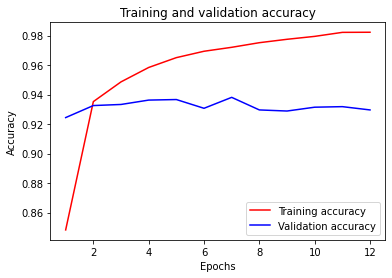

In [383]:
plot_accuracy(history)

**Classification Report on validation data:**

(validation data was used by the model for estimating performance, but model was not trained on it!)

In [384]:
preds = model.predict(X_valid, verbose=0)
# Classification report
print(classification_report(y_valid.argmax(axis=1), preds.argmax(axis=1)))

_, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print('Accuracy on validation: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       335
           1       0.91      0.93      0.92       620
           2       0.99      0.95      0.97       335
           3       0.83      0.84      0.83       319
           4       0.96      0.92      0.94       454
           5       0.95      0.96      0.96       636

    accuracy                           0.93      2699
   macro avg       0.93      0.93      0.93      2699
weighted avg       0.93      0.93      0.93      2699

Accuracy on validation: 93.26


**Classification Report on test data:**

In [385]:
preds = model.predict(X_test, verbose=0)
# Classification report
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       565
           1       0.92      0.94      0.93      1120
           2       0.96      0.97      0.97       536
           3       0.84      0.85      0.84       591
           4       0.94      0.95      0.95       818
           5       0.97      0.95      0.96      1133

    accuracy                           0.94      4763
   macro avg       0.94      0.94      0.94      4763
weighted avg       0.94      0.94      0.94      4763

Accuracy on test: 93.81


Seems like it help! f1-score of category #3 goes from 82-83 to 85.
So we'll add it to our model :)

**Notice**: When you go thourgh this notebook, you'll notice that this feature is already included in the initial functions, but that was done **after** this section was completed and we saw that this feature actually help us

## Cross Validation for hyper params

In [268]:
# Prepare data
X_train, X_test, y_train, y_test = get_data_for_model(test_size=0.2)

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}
Train:
	X_train: (25400, 16436) of float32
	y_train: (25400, 6) of float32
Test:
	X_test: (6351, 16436) of float32
	y_test: (6351, 6) of float32


In [269]:
# Early stopping callback for CV
es_cv = keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience=10,  # stop training when there's no improvement in loss for 10 consecutive epochs
    restore_best_weights=True
)

In [270]:
def create_model_cv(dp=0.4, optimizer='adam', init='glorot_uniform', n_neurons=128):
    model_in = ks.Input(shape=(INPUT_SHAPE,), dtype='float32', sparse=True)
    out = ks.layers.Dense(n_neurons, activation='relu', kernel_initializer=init)(model_in)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(n_neurons//2, activation='relu', kernel_initializer=init)(out)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(n_neurons//8, activation='relu', kernel_initializer=init)(out)
    out = ks.layers.Dense(6, activation='softmax')(out)
    model = ks.Model(model_in, out)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # rmsprop/adam
    return model

In [286]:
# Create KerasClassifier
INPUT_SHAPE = X_train.shape[1]
model_CV = KerasClassifier(
    model=create_model_cv, 
    callbacks=[es_cv], 
    loss="categorical_crossentropy",
    dp=None, 
    optimizer=None, 
    init=None, 
    n_neurons=None
)

#### Define parameters for grid search

In [287]:
dp = [0.2, 0.4, 0.6]
optimizer = ["adam"]
batches = [16]
n_neurons = [128, 192, 256]
epochs = [3, 6, 10]

param_grid = dict(
    batch_size=batches,
    dp=dp, 
    optimizer=optimizer,
    epochs=epochs,
    n_neurons=n_neurons
)

param_grid

{'batch_size': [16],
 'dp': [0.2, 0.4, 0.6],
 'optimizer': ['adam'],
 'epochs': [3, 6, 10],
 'n_neurons': [128, 192, 256]}

In [288]:
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=3, verbose=2)

In [289]:
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Epoch 1/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.3780 - accuracy: 0.8736
Epoch 2/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1505 - accuracy: 0.9492
Epoch 3/3
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.2, epochs=3, n_neurons=128, optimizer=adam; total time=  15.9s
Epoch 1/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.3852 - accuracy: 0.8807
Epoch 2/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1431 - accuracy: 0.9506
Epoch 3/3
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.2, epochs=3, n_neurons=128, optimizer=adam; total time=  15.5s
Epoch 1/3
1059/1059 [==============================] - 5s 4ms/step - loss: 0.3820 - accuracy: 0.8766
Epoch 2/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1479 - accuracy: 0.9486
Epoch 3/3
530/530 [

1059/1059 [==============================] - 5s 5ms/step - loss: 0.0659 - accuracy: 0.9752
Epoch 5/6
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0509 - accuracy: 0.9815
Epoch 6/6
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.2, epochs=6, n_neurons=192, optimizer=adam; total time=  34.9s
Epoch 1/6
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3353 - accuracy: 0.8867
Epoch 2/6
1059/1059 [==============================] - 8s 7ms/step - loss: 0.1413 - accuracy: 0.9515
Epoch 3/6
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0909 - accuracy: 0.9682
Epoch 4/6
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0667 - accuracy: 0.9747
Epoch 5/6
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0504 - accuracy: 0.9811
Epoch 6/6
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.2, epochs=6, n_neurons=256, optimizer=adam; total ti

1059/1059 [==============================] - 6s 5ms/step - loss: 0.0234 - accuracy: 0.9913
Epoch 10/10
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.2, epochs=10, n_neurons=192, optimizer=adam; total time=  57.9s
Epoch 1/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.3530 - accuracy: 0.8840
Epoch 2/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.1415 - accuracy: 0.9514
Epoch 3/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0936 - accuracy: 0.9658
Epoch 4/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0702 - accuracy: 0.9756
Epoch 5/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0524 - accuracy: 0.9800
Epoch 6/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0416 - accuracy: 0.9843
Epoch 7/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0336 - accuracy: 0.9878
Epoch 8/10
1059/1059 [=============

1059/1059 [==============================] - 9s 8ms/step - loss: 0.3868 - accuracy: 0.8712
Epoch 2/3
1059/1059 [==============================] - 8s 7ms/step - loss: 0.1659 - accuracy: 0.9473
Epoch 3/3
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.4, epochs=3, n_neurons=256, optimizer=adam; total time=  29.1s
Epoch 1/3
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3789 - accuracy: 0.8720
Epoch 2/3
1059/1059 [==============================] - 8s 8ms/step - loss: 0.1663 - accuracy: 0.9443
Epoch 3/3
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.4, epochs=3, n_neurons=256, optimizer=adam; total time=  27.5s
Epoch 1/6
1059/1059 [==============================] - 4s 4ms/step - loss: 0.4513 - accuracy: 0.8489
Epoch 2/6
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1929 - accuracy: 0.9395
Epoch 3/6
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1343 - accura

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0678 - accuracy: 0.9768
Epoch 7/10
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0591 - accuracy: 0.9800
Epoch 8/10
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0523 - accuracy: 0.9813
Epoch 9/10
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0504 - accuracy: 0.9831
Epoch 10/10
530/530 [==============================] - 1s 1ms/step
[CV] END batch_size=16, dp=0.4, epochs=10, n_neurons=128, optimizer=adam; total time=  43.6s
Epoch 1/10
1059/1059 [==============================] - 11s 4ms/step - loss: 0.4759 - accuracy: 0.8410
Epoch 2/10
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1877 - accuracy: 0.9406
Epoch 3/10
1059/1059 [==============================] - 5s 5ms/step - loss: 0.1316 - accuracy: 0.9572
Epoch 4/10
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1031 - accuracy: 0.9664
Epoch 5/10
1059/1059 [============

1059/1059 [==============================] - 8s 7ms/step - loss: 0.0627 - accuracy: 0.9787
Epoch 7/10
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0504 - accuracy: 0.9829
Epoch 8/10
1059/1059 [==============================] - 8s 8ms/step - loss: 0.0410 - accuracy: 0.9854
Epoch 9/10
1059/1059 [==============================] - 8s 8ms/step - loss: 0.0362 - accuracy: 0.9874
Epoch 10/10
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.4, epochs=10, n_neurons=256, optimizer=adam; total time= 1.5min
Epoch 1/10
1059/1059 [==============================] - 9s 8ms/step - loss: 0.3847 - accuracy: 0.8729
Epoch 2/10
1059/1059 [==============================] - 7s 7ms/step - loss: 0.1648 - accuracy: 0.9451
Epoch 3/10
1059/1059 [==============================] - 9s 8ms/step - loss: 0.1204 - accuracy: 0.9586
Epoch 4/10
1059/1059 [==============================] - 8s 8ms/step - loss: 0.0886 - accuracy: 0.9672
Epoch 5/10
1059/1059 [=============

1059/1059 [==============================] - 6s 5ms/step - loss: 0.5309 - accuracy: 0.8175
Epoch 2/6
1059/1059 [==============================] - 5s 5ms/step - loss: 0.2371 - accuracy: 0.9251
Epoch 3/6
1059/1059 [==============================] - 5s 5ms/step - loss: 0.1887 - accuracy: 0.9425
Epoch 4/6
1059/1059 [==============================] - 5s 5ms/step - loss: 0.1563 - accuracy: 0.9512
Epoch 5/6
1059/1059 [==============================] - 5s 5ms/step - loss: 0.1313 - accuracy: 0.9571
Epoch 6/6
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.6, epochs=6, n_neurons=192, optimizer=adam; total time=  34.6s
Epoch 1/6
1059/1059 [==============================] - 6s 5ms/step - loss: 0.5391 - accuracy: 0.8155
Epoch 2/6
1059/1059 [==============================] - 6s 6ms/step - loss: 0.2335 - accuracy: 0.9293
Epoch 3/6
1059/1059 [==============================] - 6s 5ms/step - loss: 0.1831 - accuracy: 0.9431
Epoch 4/6
1059/1059 [========================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.2378 - accuracy: 0.9259
Epoch 3/10
1059/1059 [==============================] - 6s 6ms/step - loss: 0.1896 - accuracy: 0.9398
Epoch 4/10
1059/1059 [==============================] - 8s 7ms/step - loss: 0.1543 - accuracy: 0.9506
Epoch 5/10
1059/1059 [==============================] - 7s 7ms/step - loss: 0.1343 - accuracy: 0.9570
Epoch 6/10
1059/1059 [==============================] - 7s 6ms/step - loss: 0.1167 - accuracy: 0.9617
Epoch 7/10
1059/1059 [==============================] - 6s 6ms/step - loss: 0.1056 - accuracy: 0.9663
Epoch 8/10
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0929 - accuracy: 0.9704
Epoch 9/10
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0889 - accuracy: 0.9711
Epoch 10/10
530/530 [==============================] - 1s 2ms/step
[CV] END batch_size=16, dp=0.6, epochs=10, n_neurons=192, optimizer=adam; total time= 1.2min
Epoch 1/10
1059/1059 [=============

In [291]:
means = np.round(100*grid_result.cv_results_['mean_test_score'], 4)
stds = 100*grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

d = pd.DataFrame(params)
d['Mean'] = means
d['Std. Dev'] = stds

d.sort_values("Mean", ascending=False).drop(columns=["batch_size", "optimizer"])

,dp,epochs,n_neurons,Mean,Std. Dev
25,0.6,10,192,93.3976,0.207484
24,0.6,10,128,93.3662,0.230753
19,0.6,3,192,93.3622,0.075154
9,0.4,3,128,93.3465,0.154075
20,0.6,3,256,93.3386,0.105761
23,0.6,6,256,93.3268,0.352725
22,0.6,6,192,93.3268,0.057542
21,0.6,6,128,93.2874,0.206028
26,0.6,10,256,93.2480,0.184312
18,0.6,3,128,93.2165,0.155946


**Classification Report on test data:**

In [292]:
preds = grid.predict(X_test)
# Classification report
report = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1))
print(report)

print('Accuracy on test: %.2f' % round(100*accuracy_score(y_test, preds), 4))

397/397 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       744
           1       0.92      0.93      0.92      1508
           2       0.97      0.97      0.97       719
           3       0.82      0.86      0.84       765
           4       0.96      0.94      0.95      1093
           5       0.97      0.96      0.97      1522

    accuracy                           0.94      6351
   macro avg       0.94      0.94      0.94      6351
weighted avg       0.94      0.94      0.94      6351

Accuracy on test: 93.92


### Before we continue, let's train this model on all data and save a prediction in the test set, in case this will be one of our final models:

In [293]:
train_data, y = load_train_data()
train_data, _, test_data = prepare_inputs(train_data, train_data, has_valid=False)

y, _ = prepare_targets(y, y, has_valid=False)

print("Train:")
print(f'\ttrain_data: {train_data.shape} of {train_data.dtype}')
print(f'\ty: {y.shape} of {y.dtype}')
print("Test:")
print(f'\ttest_data: {test_data.shape} of {test_data.dtype}')

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}
Train:
	train_data: (31751, 16444) of float32
	y: (31751, 6) of float32
Test:
	test_data: (3525, 16444) of float32


In [295]:
grid.best_params_

{'batch_size': 16,
 'dp': 0.6,
 'epochs': 10,
 'n_neurons': 192,
 'optimizer': 'adam'}

In [298]:
# Fit model on all train data
INPUT_SHAPE = train_data.shape[1]
model_CV_2 = create_model_cv(
    dp=0.6, 
    optimizer='adam',  
    n_neurons=192
)
history = model_CV_2.fit(
    train_data,
    y,
    epochs=10,
    batch_size=16,
    verbose=2
)

Epoch 1/10
1985/1985 - 9s - loss: 0.4076 - accuracy: 0.8657 - 9s/epoch - 5ms/step
Epoch 2/10
1985/1985 - 10s - loss: 0.2203 - accuracy: 0.9329 - 10s/epoch - 5ms/step
Epoch 3/10
1985/1985 - 10s - loss: 0.1835 - accuracy: 0.9415 - 10s/epoch - 5ms/step
Epoch 4/10
1985/1985 - 10s - loss: 0.1581 - accuracy: 0.9497 - 10s/epoch - 5ms/step
Epoch 5/10
1985/1985 - 10s - loss: 0.1394 - accuracy: 0.9561 - 10s/epoch - 5ms/step
Epoch 6/10
1985/1985 - 10s - loss: 0.1294 - accuracy: 0.9586 - 10s/epoch - 5ms/step
Epoch 7/10
1985/1985 - 11s - loss: 0.1158 - accuracy: 0.9622 - 11s/epoch - 5ms/step
Epoch 8/10
1985/1985 - 11s - loss: 0.1055 - accuracy: 0.9654 - 11s/epoch - 6ms/step
Epoch 9/10
1985/1985 - 11s - loss: 0.0957 - accuracy: 0.9682 - 11s/epoch - 5ms/step
Epoch 10/10
1985/1985 - 11s - loss: 0.0891 - accuracy: 0.9705 - 11s/epoch - 5ms/step


In [251]:
grid.best_params_

{'batch_size': 16,
 'dp': 0.6,
 'init': 'glorot_uniform',
 'n_neurons': 256,
 'optimizer': 'rmsprop'}

#### Sanity check on train data

In [300]:
preds = model_CV_2.predict(train_data)
# Classification report
print(classification_report(y.argmax(axis=1), preds.argmax(axis=1)))
accuracy = sum(preds.argmax(axis=1) == y.argmax(axis=1)) / len(preds)
print('Accuracy on train: %.2f' % (accuracy*100))

993/993 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3786
           1       0.99      0.95      0.97      7584
           2       0.99      1.00      1.00      3680
           3       0.90      0.98      0.94      3772
           4       0.99      0.99      0.99      5284
           5       1.00      0.99      0.99      7645

    accuracy                           0.98     31751
   macro avg       0.98      0.99      0.98     31751
weighted avg       0.98      0.98      0.98     31751

Accuracy on train: 98.23


#### Predict on test data and save results

In [301]:
preds = model_CV_2.predict(test_data).argmax(axis=1)
preds = [mapping[i] for i in preds]
test_indexes = load_test_data().idx

111/111 [==============================] - 0s 2ms/step


In [302]:
results_model_02 = pd.DataFrame({"idx": indexes, "pred_cat": preds})
results_model_02.to_csv("model_02.csv", index=False)

# For sanity check
t = load_test_data()
t["pred_cat"] = preds
t.to_csv("model_02_check.csv", index=False)

### Conclusions

Well, seems like the different hyperparameters don't affect that much the network's performance, as we see the accuracy for all of them is not very different, and there's no clear answer whether it improved the model.

## Adding the predictions from our CNN

We decided to seperatly train our CNN on the images, and add its predictions as another feature for our tabular data.
We understand that its both not the most correct and elegant way to combine them, and the better way would be to combine 2 networks together and add some dense layers after that, and also that it might cause us to overfit on the training data.
We chose this way beacuse of time constrains - we tried buiding a combined NN but we got a little bit confused and things didn't work for us.
We'll be hyper aware of overfitting when we check if this new feature is helpful :)

First step we did was add the "with_cnn" flag to all relevant functions, so that if we choose to add this feature to the model, we'll be able to.

But, in order to fairly check whether this feature improves the model, we did the following:
- Trained the CNN on 70% of the data, left 30% for test.
- Saved the indexes we used for test, and seperated our tabular data exactly the same - so we won't predict on products which their image we used as a training image.

Therefore, the following code is to manually create these dfs. It's a bit messy and we apologize for it :). If we had more time we would better integrate this as part of the already created functions.

(Code is hidden, appears in the notebook)

In [198]:
# Read test indexes
indexes_valid_images = pd.read_csv("./valid_images_indexes.csv").image.tolist()

In [199]:
# Get data (Manually, as we need the specific indexes we used as validation data in the CNN)

df = prepare_unified_df(test=False)
# Add cnn predictions as feature
cnn_df = pd.DataFrame()
for category_name in mapping.values():
    tmp_df = pd.read_csv(f"./cnn_predictions/{category_name}.csv")
    cnn_df = pd.concat([cnn_df, tmp_df])
cnn_df = cnn_df.astype(int)
cnn_df = cnn_df.sort_values('img', ignore_index=True)
cnn_df = cnn_df.rename(columns={"prediction": "cnn_prediction"})
df = df.merge(cnn_df, left_on="idx", right_on="img")
df["cnn_prediction"] = df.cnn_prediction.apply(lambda x: mapping[x])

# Seperate df to train and test according to our indexes
df_test = df.loc[df['idx'].isin(indexes_valid_images)]
df_train = df.loc[~df['idx'].isin(indexes_valid_images)]

# Seperate to X and y for train and test
X_train = df_train.drop(["category"], axis=1)
X_test = df_test.drop(["category"], axis=1)
y_train = df_train["category"]
y_test = df_test["category"]

# Prepare X data
preprocessed_X_train = preprocess(X_train, with_cnn=True)
preprocessed_X_test = preprocess(X_test, with_cnn=True)
preprocessed_X_train = add_num_of_ings_col(preprocessed_X_train)
preprocessed_X_test = add_num_of_ings_col(preprocessed_X_test)
scaler = StandardScaler()
scaler.fit(preprocessed_X_train.serving_size.values.reshape(-1, 1))
preprocessed_X_train["serving_size"] = scaler.transform(preprocessed_X_train.serving_size.values.reshape(-1, 1))
preprocessed_X_test["serving_size"] = scaler.transform(preprocessed_X_test.serving_size.values.reshape(-1, 1))
vectorizer_cnn = create_vectorizer(with_cnn=True)
X_train_cnn = vectorizer_cnn.fit_transform(preprocessed_X_train).astype(np.float32).toarray()
X_test_cnn = vectorizer_cnn.transform(preprocessed_X_test).astype(np.float32).toarray()

X_valid_cnn = X_test_cnn[0:3174]
X_test_cnn = X_test_cnn[3174:]

# Prepate y data
y_train_cnn, y_test_cnn = prepare_targets(y_train, y_test, has_valid=False)
y_valid_cnn = y_test_cnn[0:3174]
y_test_cnn = y_test_cnn[3174:]

{'cakes_cupcakes_snack_cakes': 0, 'candy': 1, 'chips_pretzels_snacks': 2, 'chocolate': 3, 'cookies_biscuits': 4, 'popcorn_peanuts_seeds_related_snacks': 5}


In [200]:
# Sanity check
print("Train:")
print(f'\tX_train_cnn: {X_train_cnn.shape} of {X_train_cnn.dtype}')
print(f'\ty_train_cnn: {y_train_cnn.shape} of {y_train_cnn.dtype}')
print("Validation:")
print(f'\tX_valid_cnn: {X_valid_cnn.shape} of {X_valid_cnn.dtype}')
print(f'\ty_valid_cnn: {y_valid_cnn.shape} of {y_valid_cnn.dtype}')
print("Test:")
print(f'\tX_test_cnn: {X_test_cnn.shape} of {X_test_cnn.dtype}')
print(f'\ty_test_cnn: {y_test_cnn.shape} of {y_test_cnn.dtype}')

Train:
	X_train_cnn: (22228, 16442) of float32
	y_train_cnn: (22228, 6) of float32
Validation:
	X_valid_cnn: (3174, 16442) of float32
	y_valid_cnn: (3174, 6) of float32
Test:
	X_test_cnn: (6349, 16442) of float32
	y_test_cnn: (6349, 6) of float32


In [201]:
# Early stopping callback
es_cnn = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,  # stop training when there's no improvement in val_loss for 15 consecutive epochs
    restore_best_weights=True
)

In [202]:
# Same model we used in our first model
def create_model_cnn(dp=0.4, optimizer='adam', num_nuerons=[128, 32, 16]):
    model_in = ks.Input(shape=(INPUT_SHAPE,), dtype='float32', sparse=True)
    out = ks.layers.Dense(num_nuerons[0], activation='relu')(model_in)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(num_nuerons[1], activation='relu')(out)
    out = ks.layers.Dropout(dp)(out)
    out = ks.layers.Dense(num_nuerons[2], activation='relu')(out)
    out = ks.layers.Dense(6, activation='softmax')(out)
    model = ks.Model(model_in, out)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # rmsprop/adam
    return model

In [203]:
# Create model
INPUT_SHAPE = X_train_cnn.shape[1]
model = create_model_cnn()

# Fit model on training data
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    callbacks=[es_cnn],
    epochs=10000,
    shuffle=True,
    validation_data=(X_valid_cnn, y_valid_cnn),
    verbose=2
)

Epoch 1/10000
695/695 - 4s - loss: 0.5441 - accuracy: 0.8276 - val_loss: 0.2704 - val_accuracy: 0.9099 - 4s/epoch - 5ms/step
Epoch 2/10000
695/695 - 4s - loss: 0.1956 - accuracy: 0.9441 - val_loss: 0.2496 - val_accuracy: 0.9206 - 4s/epoch - 6ms/step
Epoch 3/10000
695/695 - 4s - loss: 0.1485 - accuracy: 0.9556 - val_loss: 0.2424 - val_accuracy: 0.9225 - 4s/epoch - 6ms/step
Epoch 4/10000
695/695 - 3s - loss: 0.1199 - accuracy: 0.9637 - val_loss: 0.2925 - val_accuracy: 0.9159 - 3s/epoch - 5ms/step
Epoch 5/10000
695/695 - 4s - loss: 0.1012 - accuracy: 0.9697 - val_loss: 0.2712 - val_accuracy: 0.9231 - 4s/epoch - 5ms/step
Epoch 6/10000
695/695 - 4s - loss: 0.0925 - accuracy: 0.9711 - val_loss: 0.2655 - val_accuracy: 0.9294 - 4s/epoch - 5ms/step
Epoch 7/10000
695/695 - 4s - loss: 0.0783 - accuracy: 0.9754 - val_loss: 0.2870 - val_accuracy: 0.9231 - 4s/epoch - 5ms/step
Epoch 8/10000
695/695 - 4s - loss: 0.0733 - accuracy: 0.9777 - val_loss: 0.3084 - val_accuracy: 0.9263 - 4s/epoch - 6ms/step


### Evaluate Model

**Plotting training and validation accuracy:**

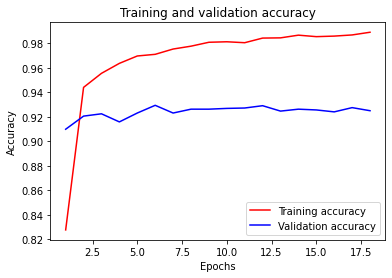

In [204]:
plot_accuracy(history)

**Classification Report on validation data:**

(validation data was used by the model for estimating performance, but model was not trained on it!)

In [205]:
preds = model.predict(X_test_cnn, verbose=0)
# Classification report
print(classification_report(y_test_cnn.argmax(axis=1), preds.argmax(axis=1)))
_, accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Accuracy on test: %.2f' % (accuracy*100))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1079
           1       0.87      0.90      0.89      1509
           2       0.94      0.95      0.94       648
           3       0.74      0.73      0.73       758
           4       0.92      0.90      0.91       981
           5       0.93      0.93      0.93      1374

    accuracy                           0.90      6349
   macro avg       0.89      0.89      0.89      6349
weighted avg       0.90      0.90      0.90      6349

Accuracy on test: 89.84


Looks like we do much worse here, so we're not gonna include it in one of our predictions :(

We think it's because our CNN model does very poorly on chocolate, but pretty good on all other categories. So what happens is this model believes our CNN prediction as generally it's a good one, and therefore performs now poorly on chocolate as well.

We have ideas our to improve this:
- Perform CV with this feature as well.
- Engineer this feature in another way - maybe ignore the CNNs prediction for chocolate, and create less features that indicate whether our CNN thinks the product belongs to some other category (but only categories it performs well on).
- Improve our CNN, of course.
- Engineer additional features for chocolate that maybe will help balance the CNNs predictions.

We just don't have time to do these, but we wanted to mention them.

<img src="./images/meme4.png"
     alt="another meme"
     width="400"
     height="400"
     style="float: left; margin-right: 10px;" />